Mengimport library menggunakan TensorFlow backend

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from tensorflow.keras.layers import Input,Dense,concatenate,Dropout,Conv1D,Bidirectional,LSTM,SimpleRNN
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
from tabulate import tabulate
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['datetime', 'sqrt', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy



Mengimport dataset saham BMRI.JK dari 1 Januari 2017 sampai 16 November 2022

In [2]:
datasaham = pd.read_csv('../input/bmriprice/BMRI.JK.csv',index_col="Date")
datasaham.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1475 entries, 1/2/2017 to 11/15/2022
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1474 non-null   float64
 1   High       1474 non-null   float64
 2   Low        1474 non-null   float64
 3   Close      1474 non-null   float64
 4   Adj Close  1474 non-null   float64
 5   Volume     1474 non-null   float64
dtypes: float64(6)
memory usage: 80.7+ KB


In [3]:
datasaham.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1/2/2017,5787.5,5787.5,5787.5,5787.5,4575.018066,0.0
1/3/2017,5787.5,5787.5,5600.0,5650.0,4466.324707,25206000.0
1/4/2017,5650.0,5675.0,5562.5,5675.0,4486.086914,20555200.0
1/5/2017,5600.0,5662.5,5575.0,5625.0,4446.562500,33277200.0
1/6/2017,5675.0,5712.5,5637.5,5687.5,4495.968262,27168800.0


Buat Plot

In [4]:
bmri_trace = go.Scatter(x=datasaham.index, y=datasaham['Close'], name= 'Price')
py.iplot([bmri_trace])

Using Close Price as a feature to train the LSTM model. Use MinMaxScaler to normalize Close Price to range from 0 to 1

In [5]:
datasaham['Close'].replace(0, np.nan, inplace=True)
datasaham['Close'].fillna(method='ffill', inplace=True)

In [6]:
from sklearn.preprocessing import MinMaxScaler
values = datasaham['Close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Split 70% of data for training and 30% for testing

In [7]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1032 443


Create function for creating dataset with look back

In [8]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

Generate dataset for trainX, trainY, testX, testY

In [9]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1031
442


Reshape X for model training

In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Running the LSTM model with 100 epochs

In [11]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

2022-11-30 14:02:18.245863: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-11-30 14:02:18.676699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


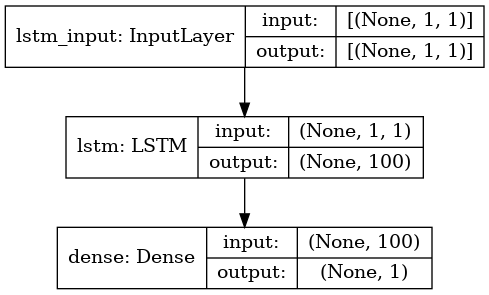

In [12]:
plot_model(model, to_file='LSTM model.png', show_shapes=True)

Plot line graph to show amount loss according the the epoch

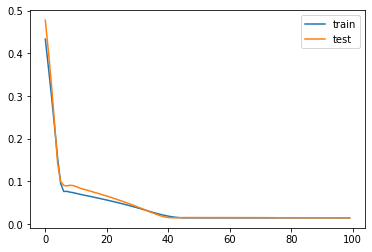

In [13]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Make prediction using textX and plotting line graph against testY

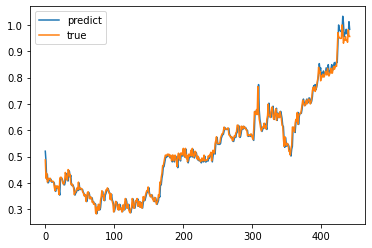

In [14]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

Scaler Inverse Y back to normal value

In [15]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

RMSE

In [16]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 138.871


Plot line graph with Y as Close Price 

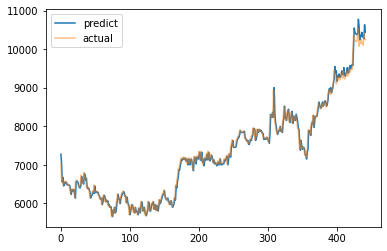

In [17]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

Convert X to dates

In [18]:
predictDates = datasaham.tail(len(testX)).index


Reshape testY and yhat for plotly

In [19]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

Plot predicted and actual line graph with X=dates, Y=Close Price 

In [20]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

Convert array that consist of testY_reshape and yhat_reshape to matrix so that it can be dataframe form 

In [21]:
actual = np.mat(testY_reshape).reshape(1, int(np.prod(np.mat(testY_reshape).shape))).T
predict = np.mat(yhat_reshape).reshape(1, int(np.prod(np.mat(yhat_reshape).shape))).T

Dataframe that consist of actual price and predict price 

In [22]:
actualtable = pd.DataFrame(actual,columns=['Actual Price'])
actualtable
predicttable = pd.DataFrame(predict,columns=['Predict Price'])
result = pd.concat([actualtable,predicttable], axis=1, join='inner')
display(result)

,Actual Price,Predict Price
0,7050.0,7275.555664
1,6575.0,7023.337891
2,6700.0,6551.321777
3,6475.0,6674.613281
4,6500.0,6453.167969
...,...,...
437,10150.0,10323.066406
438,10100.0,10323.066406
439,10425.0,10267.054688
440,10250.0,10632.618164


Using additional features for model training

ind correlation in features to Close Price

<AxesSubplot:>

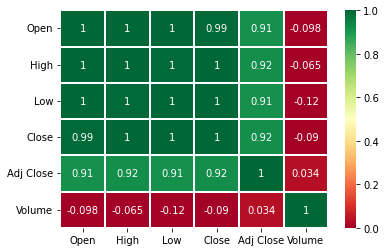

In [23]:
sns.heatmap(datasaham.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

Function to convert series to supervised learning

In [24]:
def series_to_supervised(datasaham, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(datasaham) is list else datasaham.shape[1]
    df = pd.DataFrame(datasaham)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


Get all data values

In [25]:
#values = datasaham[['Close']]
values = datasaham[['Close'] + ['Volume']].values
values = values.astype('float32')
print(values)

[[5.78750e+03 0.00000e+00]
 [5.65000e+03 2.52060e+07]
 [5.67500e+03 2.05552e+07]
 ...
 [1.04250e+04 5.10041e+07]
 [1.02500e+04 3.05276e+07]
 [1.02500e+04 4.15004e+07]]


Normalize features to range from 0 to 1

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Frame as supervised learning

In [27]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.302709,0.000000,0.282577,0.101139
2,0.282577,0.101139,0.286237,0.082477
3,0.286237,0.082477,0.278917,0.133524
4,0.278917,0.133524,0.288067,0.109014
5,0.288067,0.109014,0.280747,0.072925



Drop unncessary columns

In [28]:
reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)   var1(t)
1   0.302709   0.000000  0.282577
2   0.282577   0.101139  0.286237
3   0.286237   0.082477  0.278917
4   0.278917   0.133524  0.288067
5   0.288067   0.109014  0.280747


Split data to 70% training, 30% testing

In [29]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1030, 1, 2) (1030,) (442, 1, 2) (442,)


Training the LSTM model with 100 epochs

In [30]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

Plot line graph to show amount loss according the the epoch

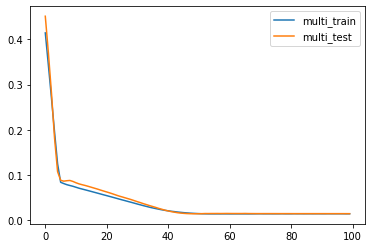

In [31]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

Make prediction using textX and plotting line graph against testY

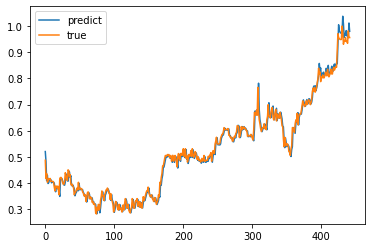

In [32]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

Scaler Inverse Y back to normal value

In [33]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

RMSE

In [34]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 140.845


Plot line graph with actual price, predicted price with feature Close Price, predicted price with features Volume and Close Price

In [35]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])

Convert array that consist of testY_reshape and yhat_reshape to matrix so that it can be dataframe form 

In [36]:
import numpy as np
dataactual = np.mat(inv_y).reshape(1, int(np.prod(np.mat(inv_y).shape))).T
datamultipredict = np.mat(inv_yhat).reshape(1, int(np.prod(np.mat(inv_yhat).shape))).T
datapredict = np.mat(yhat_reshape).reshape(1, int(np.prod(np.mat(yhat_reshape).shape))).T

Dataframe that consist of actual price and predict price 

In [37]:
# Also, you can turn it into Data Frame:
import pandas as pd
actualtable = pd.DataFrame(dataactual,columns=['Actual Price'])
actualtable
multipredicttable = pd.DataFrame(datamultipredict,columns=['Multi Predict Price'])
multipredicttable
predicttable = pd.DataFrame(datapredict,columns=['Predict Price'])
result = pd.concat([actualtable,multipredicttable,predicttable], axis=1, join='inner')
display(result)

,Actual Price,Multi Predict Price,Predict Price
0,7050.0,7276.505371,7275.555664
1,6575.0,7022.079102,7023.337891
2,6700.0,6514.574219,6551.321777
3,6475.0,6658.228027,6674.613281
4,6500.0,6443.250488,6453.167969
...,...,...,...
437,10150.0,10291.376953,10323.066406
438,10100.0,10305.497070,10323.066406
439,10425.0,10247.087891,10267.054688
440,10250.0,10629.619141,10632.618164


Save the dataframe result to csv form 

In [38]:
result.to_csv('mycsvfile.csv',index=False)